# Autocorrelation-based boundary detection

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.graph import Graph
from esda import Moran_Local, Geary_Local
from sklearn.decomposition import PCA

Load all buildings represented as points.

In [3]:
complete = gpd.read_parquet("/data/uscuni-boundaries/classification/v202511/").reset_index(drop=True)

In [4]:
complete

,geometry,level_7_label,area
0,POINT (4292815.658 3392096.245),36,124.350225
1,POINT (4292819.583 3392091.712),36,1.402272
2,POINT (4292810.814 3392094.661),36,14.988636
3,POINT (4292809.522 3392043.982),36,23.192214
4,POINT (4294130.039 3392097.282),57,65.245111
...,...,...,...
159599314,POINT (4128415.517 2896813.41),26,55.429514
159599315,POINT (4128415.095 2896819.459),26,59.189652
159599316,POINT (4128396.856 2896812.442),26,34.162277
159599317,POINT (4128396.626 2896802.56),26,16.241510


Map ids to level 3.

In [24]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
complete["level_3"] = complete.level_7_label.map(final_clusters[3])
complete

,geometry,level_7_label,area,level_3
0,POINT (4292815.658 3392096.245),36,124.350225,4
1,POINT (4292819.583 3392091.712),36,1.402272,4
2,POINT (4292810.814 3392094.661),36,14.988636,4
3,POINT (4292809.522 3392043.982),36,23.192214,4
4,POINT (4294130.039 3392097.282),57,65.245111,5
...,...,...,...,...
159599314,POINT (4128415.517 2896813.41),26,55.429514,3
159599315,POINT (4128415.095 2896819.459),26,59.189652,3
159599316,POINT (4128396.856 2896812.442),26,34.162277,3
159599317,POINT (4128396.626 2896802.56),26,16.241510,3


Make a grid

In [6]:
grid_size = 50_000

In [7]:
bds = complete.total_bounds
bds

array([1548185.539145  ,  942249.56623092, 5378847.07173358,
       3799811.41843362])

In [8]:
x = np.arange(bds[0], bds[2], grid_size)
y = np.arange(bds[1], bds[3], grid_size)

In [9]:
xs, ys = np.meshgrid(x, y)

In [10]:
grid = gpd.GeoSeries.from_xy(x=xs.flatten(), y=ys.flatten(), crs=complete.crs).buffer(
    grid_size / 2, cap_style="square"
)

Join grid label to points

In [11]:
grid = grid.to_frame("geometry")
joined = complete.sjoin(grid, predicate="within")

Group by grid label and get counts by class.

In [12]:
counts = joined.groupby("index_right").level_3.value_counts().unstack().fillna(0)
counts = counts.div(counts.sum(axis=1), axis=0)
counts

level_3,1,2,3,4,5,6,7,8
index_right,,,,,,,,
5,0.094316,0.042292,0.033973,0.098306,0.128195,0.270845,0.066629,0.265443
7,0.422699,0.000000,0.040491,0.019018,0.058282,0.087117,0.047853,0.324540
8,0.073837,0.009737,0.239632,0.226650,0.179679,0.033718,0.067616,0.169131
9,0.700855,0.123077,0.000000,0.001709,0.000000,0.000000,0.013675,0.160684
80,0.162452,0.035518,0.010065,0.108385,0.167776,0.068125,0.124272,0.323407
...,...,...,...,...,...,...,...,...
4460,0.000000,0.000000,0.007194,0.410072,0.582734,0.000000,0.000000,0.000000
4461,0.002127,0.000000,0.057781,0.385502,0.331266,0.000000,0.223325,0.000000
4462,0.002161,0.000000,0.246345,0.426084,0.296937,0.000000,0.027075,0.001398


Join

In [13]:
grid_data = pd.concat([grid, counts], axis=1)

Drop cells outside of the area

In [23]:
grid_data = grid_data.dropna().reset_index()
grid_data

,level_0,index,geometry,1,2,3,4,5,6,7,8
0,0,5,"POLYGON ((1823185.539 967249.566, 1823185.539 ...",0.094316,0.042292,0.033973,0.098306,0.128195,0.270845,0.066629,0.265443
1,1,7,"POLYGON ((1923185.539 967249.566, 1923185.539 ...",0.422699,0.000000,0.040491,0.019018,0.058282,0.087117,0.047853,0.324540
2,2,8,"POLYGON ((1973185.539 967249.566, 1973185.539 ...",0.073837,0.009737,0.239632,0.226650,0.179679,0.033718,0.067616,0.169131
3,3,9,"POLYGON ((2023185.539 967249.566, 2023185.539 ...",0.700855,0.123077,0.000000,0.001709,0.000000,0.000000,0.013675,0.160684
4,4,80,"POLYGON ((1723185.539 1017249.566, 1723185.539...",0.162452,0.035518,0.010065,0.108385,0.167776,0.068125,0.124272,0.323407
...,...,...,...,...,...,...,...,...,...,...,...
1003,1003,4460,"POLYGON ((5123185.539 3817249.566, 5123185.539...",0.000000,0.000000,0.007194,0.410072,0.582734,0.000000,0.000000,0.000000
1004,1004,4461,"POLYGON ((5173185.539 3817249.566, 5173185.539...",0.002127,0.000000,0.057781,0.385502,0.331266,0.000000,0.223325,0.000000
1005,1005,4462,"POLYGON ((5223185.539 3817249.566, 5223185.539...",0.002161,0.000000,0.246345,0.426084,0.296937,0.000000,0.027075,0.001398
1006,1006,4463,"POLYGON ((5273185.539 3817249.566, 5273185.539...",0.014259,0.005849,0.186988,0.253440,0.266306,0.000000,0.273102,0.000056


Build contiguity graph and use it ot compute Local Moran's I. 

In [15]:
contig = Graph.build_contiguity(grid_data, rook=False).transform('r')

lisa = Moran_Local(grid_data[3].fillna(0), contig)

/home/eliska/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


Get bounddaries for each cluster type and each p value

In [16]:
boundaries = []
for i in range(1, 9):
    for p in [0.1, 0.05, 0.01]:
        lisa = Moran_Local(grid_data[i].fillna(0), contig)
        lisa_graph = Graph.build_block_contiguity(lisa.get_cluster_labels() == "High-High")
        inter = contig.difference(lisa_graph)
        boundaries.append(inter)

        lisa_graph = Graph.build_block_contiguity(lisa.get_cluster_labels() == "Low-Low")
        inter = contig.difference(lisa_graph)
        boundaries.append(inter)

/home/eliska/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/eliska/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/eliska/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/eliska/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/eliska/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim =

Plot the boundaries

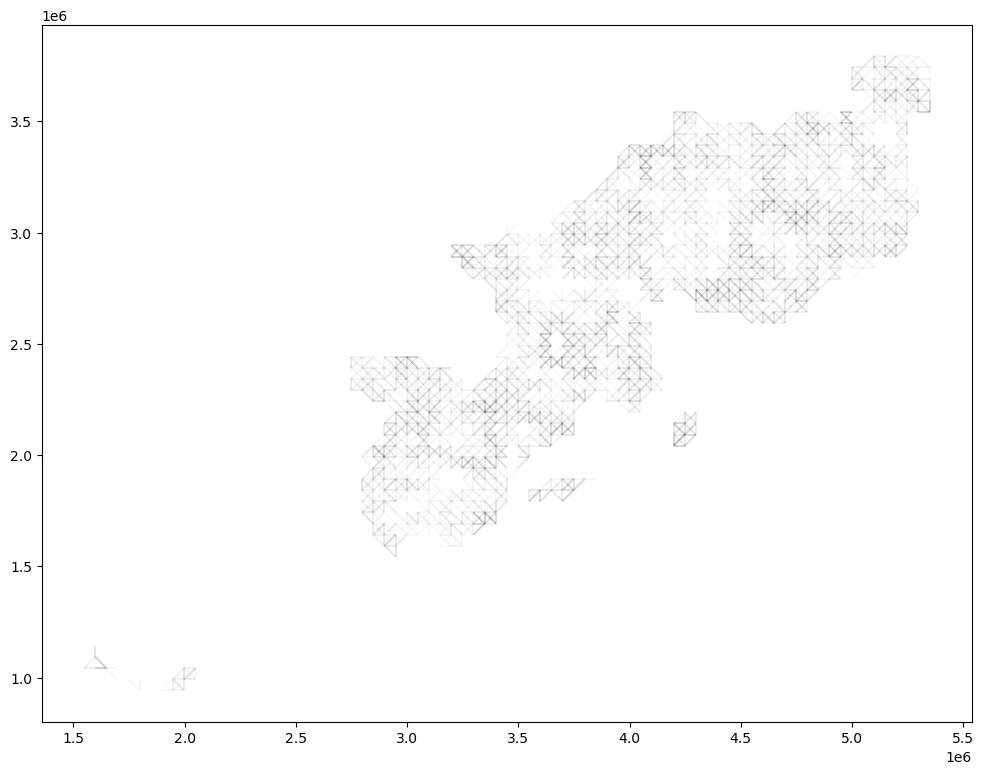

In [17]:
f, ax = plt.subplots(figsize=(12, 12))

for bound in boundaries:
    bound.plot(grid_data, ax=ax, nodes=False, edge_kws=dict(alpha=.01))
ax.set_aspect('equal')

Using PCA

In [79]:
pca = PCA().fit(grid_data.iloc[:, 3:].values)

ValueError: could not convert string to float: '#6da057'

Check variance ration

In [19]:
pca.explained_variance_ratio_

array([0.44624297, 0.24247289, 0.17279047])

Get PCAs

In [20]:
comps = pca.transform(grid_data.iloc[:, 2:].values)

Get LISA of PCA of proportions

In [38]:
lisa_comp = Moran_Local(comps[:, 1], contig)

/home/eliska/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


<Axes: >

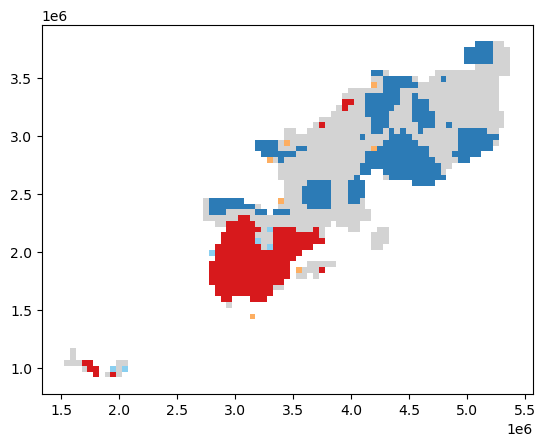

In [22]:
lisa_comp.plot(grid_data)

In [60]:
colors_raw=comps[:, :3]
colors_raw

array([[ 0.01749047,  0.31719227, -0.11656018],
       [ 0.06291709,  0.32533152, -0.08454071],
       [-0.13899119,  0.10131269,  0.06905225],
       ...,
       [-0.32211695, -0.10211922,  0.04914333],
       [-0.02264299, -0.13624853,  0.09409391],
       [-0.18832372,  0.01382246,  0.27552   ]], shape=(1008, 3))

In [61]:
def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

In [62]:
color_norm = normalize_array(colors_raw)
color_norm

array([[0.43111294, 0.63105368, 0.34168343],
       [0.4614185 , 0.63648363, 0.36304465],
       [0.32671898, 0.48703344, 0.46551146],
       ...,
       [0.20454988, 0.35131746, 0.45222958],
       [0.40433861, 0.32854869, 0.48221757],
       [0.29380766, 0.42866589, 0.60325276]], shape=(1008, 3))

In [63]:
grid_data["color"] = [
    '#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255))
    for r, g, b in color_norm
]
grid_data

,level_0,index,geometry,1,2,3,4,5,6,7,8,color
0,0,5,"POLYGON ((1823185.539 967249.566, 1823185.539 ...",0.094316,0.042292,0.033973,0.098306,0.128195,0.270845,0.066629,0.265443,#6da057
1,1,7,"POLYGON ((1923185.539 967249.566, 1923185.539 ...",0.422699,0.000000,0.040491,0.019018,0.058282,0.087117,0.047853,0.324540,#75a25c
2,2,8,"POLYGON ((1973185.539 967249.566, 1973185.539 ...",0.073837,0.009737,0.239632,0.226650,0.179679,0.033718,0.067616,0.169131,#537c76
3,3,9,"POLYGON ((2023185.539 967249.566, 2023185.539 ...",0.700855,0.123077,0.000000,0.001709,0.000000,0.000000,0.013675,0.160684,#729462
4,4,80,"POLYGON ((1723185.539 1017249.566, 1723185.539...",0.162452,0.035518,0.010065,0.108385,0.167776,0.068125,0.124272,0.323407,#768c53
...,...,...,...,...,...,...,...,...,...,...,...,...
1003,1003,4460,"POLYGON ((5123185.539 3817249.566, 5123185.539...",0.000000,0.000000,0.007194,0.410072,0.582734,0.000000,0.000000,0.000000,#3e4948
1004,1004,4461,"POLYGON ((5173185.539 3817249.566, 5173185.539...",0.002127,0.000000,0.057781,0.385502,0.331266,0.000000,0.223325,0.000000,#59475e
1005,1005,4462,"POLYGON ((5223185.539 3817249.566, 5223185.539...",0.002161,0.000000,0.246345,0.426084,0.296937,0.000000,0.027075,0.001398,#345973
1006,1006,4463,"POLYGON ((5273185.539 3817249.566, 5273185.539...",0.014259,0.005849,0.186988,0.253440,0.266306,0.000000,0.273102,0.000056,#67537a


(np.float64(1330685.5391450012),
 np.float64(5565685.539145001),
 np.float64(772249.5662309177),
 np.float64(3962249.566230918))

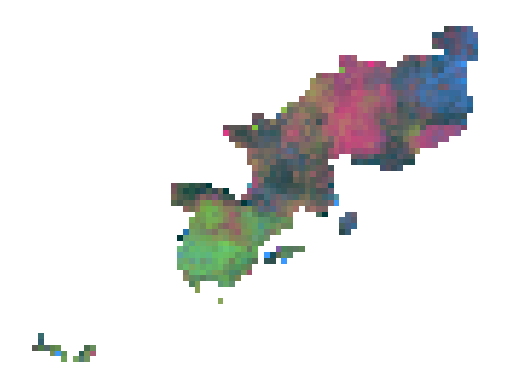

In [64]:
grid_data.plot(color=grid_data['color'])
plt.axis('off')

## Level 7

In [29]:
counts7 = joined.groupby("index_right").level_7_label.value_counts().unstack().fillna(0)
counts7 = counts7.div(counts7.sum(axis=1), axis=0)
counts7

level_7_label,1,2,3,4,5,6,7,8,9,10,...,101,102,103,104,105,106,107,108,109,110
index_right,,,,,,,,,,,,,,,,,,,,,
5,0.016582,0.012648,0.034463,0.011142,0.019481,0.0,0.0,0.0,0.015264,0.004875,...,0.017730,0.009336,0.007755,0.020045,0.027630,0.105007,0.022492,0.021777,0.0,0.033503
7,0.157669,0.000000,0.138650,0.126380,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.113497,0.032515,0.000000,0.000000,0.084663,0.084663,0.000000,0.000000,0.0,0.000000
8,0.038586,0.000000,0.034529,0.000721,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.021277,0.000000,0.000000,0.000000,0.066534,0.037865,0.010007,0.000000,0.0,0.033357
9,0.261538,0.000000,0.264957,0.174359,0.000000,0.0,0.0,0.0,0.123077,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.160684,0.000000,0.000000,0.000000,0.0,0.000000
80,0.095159,0.000000,0.015804,0.024705,0.026784,0.0,0.0,0.0,0.000000,0.028198,...,0.013143,0.000582,0.000000,0.000000,0.023207,0.168524,0.017801,0.018300,0.0,0.081850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4461,0.002127,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4462,0.002161,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [30]:
grid_data7 = pd.concat([grid, counts7], axis=1)
grid_data7 = grid_data7.dropna().reset_index()
grid_data7

,index,geometry,1,2,3,4,5,6,7,8,...,101,102,103,104,105,106,107,108,109,110
0,5,"POLYGON ((1823185.539 967249.566, 1823185.539 ...",0.016582,0.012648,0.034463,0.011142,0.019481,0.0,0.0,0.0,...,0.017730,0.009336,0.007755,0.020045,0.027630,0.105007,0.022492,0.021777,0.0,0.033503
1,7,"POLYGON ((1923185.539 967249.566, 1923185.539 ...",0.157669,0.000000,0.138650,0.126380,0.000000,0.0,0.0,0.0,...,0.113497,0.032515,0.000000,0.000000,0.084663,0.084663,0.000000,0.000000,0.0,0.000000
2,8,"POLYGON ((1973185.539 967249.566, 1973185.539 ...",0.038586,0.000000,0.034529,0.000721,0.000000,0.0,0.0,0.0,...,0.021277,0.000000,0.000000,0.000000,0.066534,0.037865,0.010007,0.000000,0.0,0.033357
3,9,"POLYGON ((2023185.539 967249.566, 2023185.539 ...",0.261538,0.000000,0.264957,0.174359,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.160684,0.000000,0.000000,0.000000,0.0,0.000000
4,80,"POLYGON ((1723185.539 1017249.566, 1723185.539...",0.095159,0.000000,0.015804,0.024705,0.026784,0.0,0.0,0.0,...,0.013143,0.000582,0.000000,0.000000,0.023207,0.168524,0.017801,0.018300,0.0,0.081850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,4460,"POLYGON ((5123185.539 3817249.566, 5123185.539...",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1004,4461,"POLYGON ((5173185.539 3817249.566, 5173185.539...",0.002127,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1005,4462,"POLYGON ((5223185.539 3817249.566, 5223185.539...",0.002161,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1006,4463,"POLYGON ((5273185.539 3817249.566, 5273185.539...",0.000836,0.000000,0.000000,0.013424,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [39]:
pca7 = PCA().fit(grid_data7.iloc[:, 2:].values)
pca7

PCA()

In [40]:
pca7.explained_variance_ratio_

array([1.20499640e-01, 1.10643505e-01, 1.02186345e-01, 5.84627024e-02,
       4.62559424e-02, 4.42545753e-02, 3.68480522e-02, 3.47491343e-02,
       3.20645642e-02, 2.97817468e-02, 2.63116554e-02, 2.21302704e-02,
       2.17282167e-02, 2.03967579e-02, 1.83698563e-02, 1.60590135e-02,
       1.52035974e-02, 1.43045089e-02, 1.34651557e-02, 1.26160788e-02,
       1.17873635e-02, 1.08464116e-02, 9.92506304e-03, 9.18028692e-03,
       8.07777229e-03, 7.96275732e-03, 7.79666830e-03, 7.42549508e-03,
       6.73655750e-03, 6.56799006e-03, 5.96329222e-03, 5.76393741e-03,
       5.25124843e-03, 5.12438384e-03, 4.91512450e-03, 4.82602024e-03,
       4.70140218e-03, 4.60948409e-03, 4.44996161e-03, 4.24829114e-03,
       4.01884192e-03, 3.88367981e-03, 3.62979480e-03, 3.52658226e-03,
       3.34332803e-03, 3.16186069e-03, 3.06787857e-03, 2.92138476e-03,
       2.71936275e-03, 2.42873486e-03, 2.26856278e-03, 2.10478277e-03,
       1.96772209e-03, 1.82799619e-03, 1.78345299e-03, 1.71722959e-03,
      

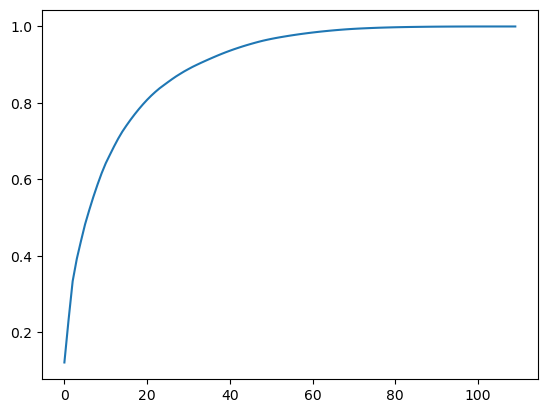

In [41]:
plt.plot(np.cumsum(pca7.explained_variance_ratio_))

In [47]:
comps7 = pca7.transform(grid_data7.iloc[:, 2:].values)

In [55]:
colors_raw=comps7[:, :3]
colors_raw

array([[ 0.0159835 ,  0.10889672,  0.05872736],
       [-0.00953733,  0.06932232,  0.02406233],
       [ 0.02120581,  0.0254802 ,  0.10830299],
       ...,
       [-0.1539703 , -0.14440293,  0.10856275],
       [-0.13131074, -0.10933691,  0.09393358],
       [-0.14170878, -0.09673145,  0.09336286]], shape=(1008, 3))

In [57]:
color_norm = normalize_array(colors_raw)
color_norm

array([[0.32993785, 0.42900992, 0.37551503],
       [0.30272534, 0.3868123 , 0.33855219],
       [0.33550633, 0.34006405, 0.42837684],
       ...,
       [0.14871847, 0.15892003, 0.42865382],
       [0.17288004, 0.19631044, 0.41305494],
       [0.16179276, 0.20975146, 0.41244638]], shape=(1008, 3))

In [58]:
grid_data7["color"] = [
    '#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255))
    for r, g, b in color_norm
]
grid_data7

,index,geometry,1,2,3,4,5,6,7,8,...,102,103,104,105,106,107,108,109,110,color
0,5,"POLYGON ((1823185.539 967249.566, 1823185.539 ...",0.016582,0.012648,0.034463,0.011142,0.019481,0.0,0.0,0.0,...,0.009336,0.007755,0.020045,0.027630,0.105007,0.022492,0.021777,0.0,0.033503,#546d5f
1,7,"POLYGON ((1923185.539 967249.566, 1923185.539 ...",0.157669,0.000000,0.138650,0.126380,0.000000,0.0,0.0,0.0,...,0.032515,0.000000,0.000000,0.084663,0.084663,0.000000,0.000000,0.0,0.000000,#4d6256
2,8,"POLYGON ((1973185.539 967249.566, 1973185.539 ...",0.038586,0.000000,0.034529,0.000721,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.066534,0.037865,0.010007,0.000000,0.0,0.033357,#55566d
3,9,"POLYGON ((2023185.539 967249.566, 2023185.539 ...",0.261538,0.000000,0.264957,0.174359,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.160684,0.000000,0.000000,0.000000,0.0,0.000000,#495c53
4,80,"POLYGON ((1723185.539 1017249.566, 1723185.539...",0.095159,0.000000,0.015804,0.024705,0.026784,0.0,0.0,0.0,...,0.000582,0.000000,0.000000,0.023207,0.168524,0.017801,0.018300,0.0,0.081850,#5c625c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,4460,"POLYGON ((5123185.539 3817249.566, 5123185.539...",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,#623d56
1004,4461,"POLYGON ((5173185.539 3817249.566, 5173185.539...",0.002127,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,#2c2769
1005,4462,"POLYGON ((5223185.539 3817249.566, 5223185.539...",0.002161,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,#25286d
1006,4463,"POLYGON ((5273185.539 3817249.566, 5273185.539...",0.000836,0.000000,0.000000,0.013424,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,#2c3269


(np.float64(1330685.5391450012),
 np.float64(5565685.539145001),
 np.float64(772249.5662309177),
 np.float64(3962249.566230918))

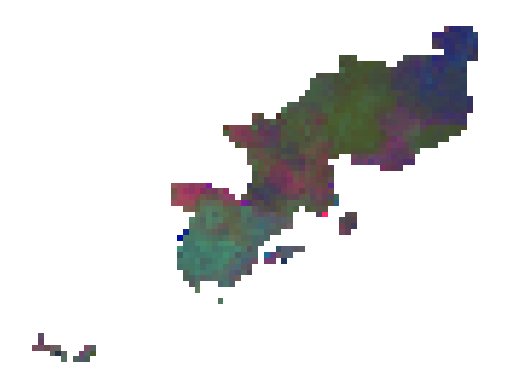

In [59]:
grid_data7.plot(color=grid_data7['color'])
plt.axis('off')

In [66]:
boundaries = gpd.read_file("ne_10m_admin_0_countries.zip")
boundaries

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Admin-0 country,0,4,China,CH1,1,2,Country,1,Macao S.A.R,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((113.5586 22.16303, 113.56943 2..."
254,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,1,Ashmore and Cartier Islands,...,None,None,None,None,None,None,None,None,None,"POLYGON ((123.59702 -12.42832, 123.59775 -12.4..."
255,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,1,Bajo Nuevo Bank (Petrel Is.),...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-79.98929 15.79495, -79.98782 15.796..."
256,Admin-0 country,6,5,Serranilla Bank,SER,0,2,Indeterminate,1,Serranilla Bank,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-78.63707 15.86209, -78.64041 15.864..."


In [69]:
import shapely

(np.float64(1330685.5391450012),
 np.float64(5565685.539145001),
 np.float64(772249.5662309177),
 np.float64(3962249.566230918))

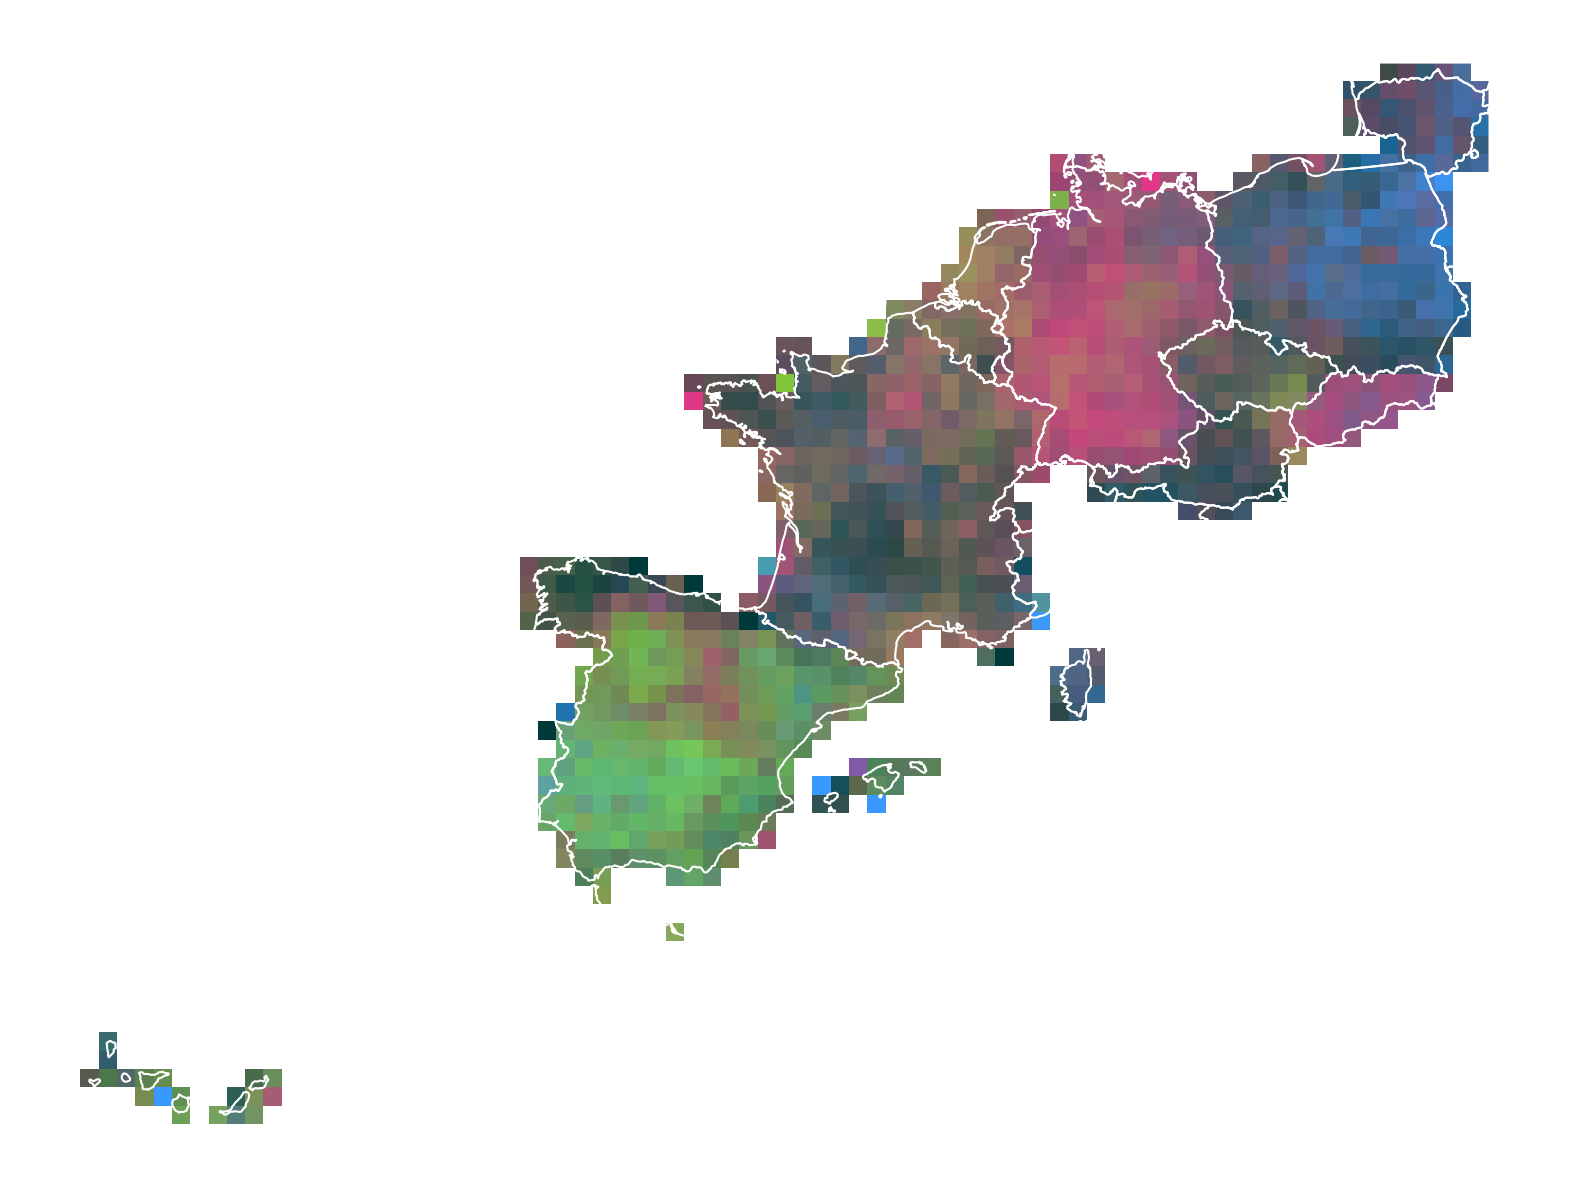

In [73]:
ax=grid_data.plot(color=grid_data['color'], figsize=(20, 20))
b = grid_data7.total_bounds
boundaries.to_crs(grid_data7.crs).clip(shapely.box(*b)).boundary.plot(ax=ax, color='w')
plt.axis('off')


(np.float64(1330685.5391450012),
 np.float64(5565685.539145001),
 np.float64(772249.5662309177),
 np.float64(3962249.566230918))

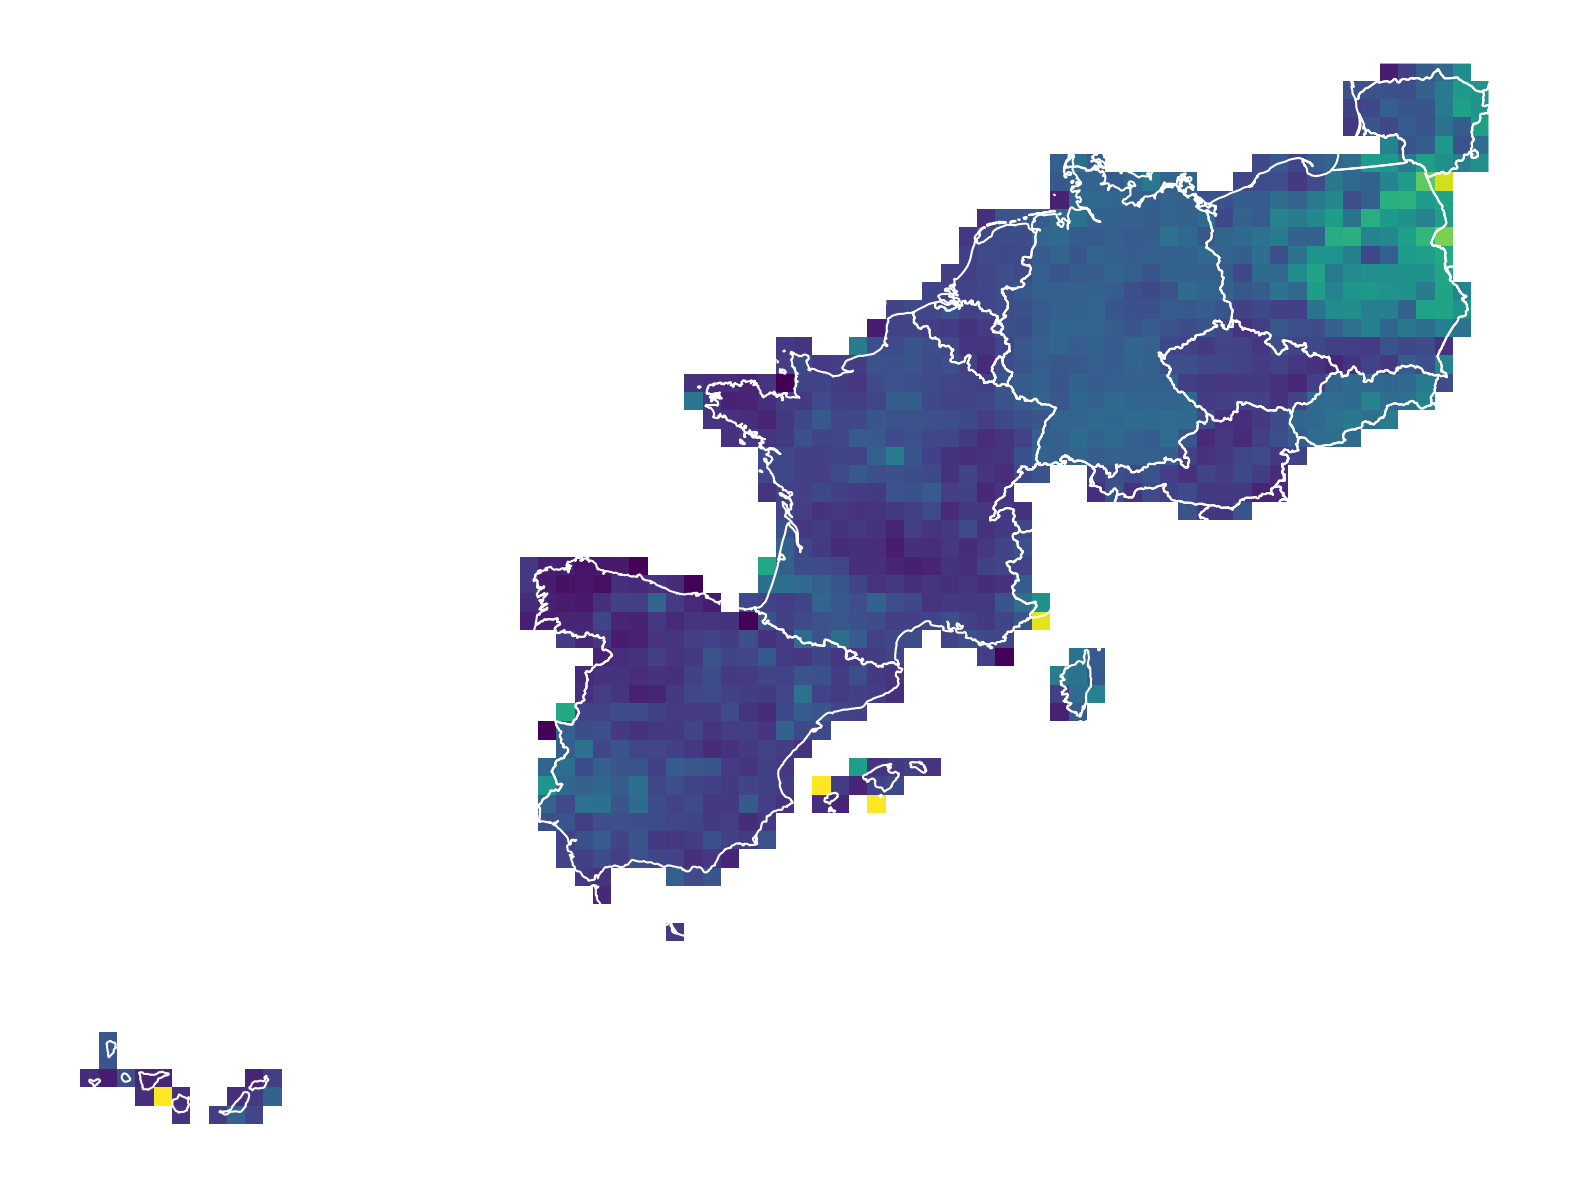

In [77]:
ax=grid_data.plot(comps[:,2], figsize=(20, 20))
b = grid_data7.total_bounds
boundaries.to_crs(grid_data7.crs).clip(shapely.box(*b)).boundary.plot(ax=ax, color='w')
plt.axis('off')